## **Решение задач семинара №2. Собираем быстрый пайплайн данных**

**Цель семинара:**
Освоить практические методы построения эффективного видеопайплайна — от параллельного чтения и сэмплинга кадров до профилирования latency и оптимизации throughput. Все задания выполняются в Python с использованием PyTorch, PyAV и инструментов профилирования.

In [1]:
#pip install kagglehub

In [2]:
# Импорт модуля и загрузка путей к видео UCF101

from video_pipeline_ucf101 import (
    get_ucf101_videos_kaggle,
    run_task1_read_clip_demo,
    run_task2_3_dataloader_num_workers_demo,
    run_task4_profile_pipeline,
    run_task5_9_fps_jitter_demo,
    run_task6_overlap_pipeline_demo,
    run_task7_decoder_compare_demo,
    run_task8_preprocess_cpu_gpu_demo,
    run_task10_near_rt_demo,
)

# загрузим небольшой поднабор UCF101 (32 файла для всех задач)
video_paths = get_ucf101_videos_kaggle(limit_videos=32)
len(video_paths), video_paths[0]

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(32,
 '/root/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi')

### Задача 1 — Проверка работы `read_clip`

В рамках первой задачи мы протестировали базовый декодер `read_clip` на одном видео из датасета **UCF101**.  
Функция успешно извлекла **8 кадров** с шагом `stride = 2`, корректно обработала **PTS/time_base** и сформировала клип размером **(8, 240, 320, 3)**.

In [3]:
# Задача 1 — проверка read_clip на одном видео

run_task1_read_clip_demo(video_paths)

Видео: /root/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
clip shape: (8, 240, 320, 3)
indices: [0, 2, 4, 6, 8, 10, 12, 14]
timestamps: [0.04, 0.16, 0.2, 0.24, 0.4, 0.44, 0.48, 0.64]
fps_est: 11.666666666666668


---
**Ключевые наблюдения:**

- Извлечённые индексы кадров: `0, 2, 4, ..., 14` — это подтверждает корректную реализацию пропуска кадров через `stride`.
- Временные метки (timestamps) возрастают неравномерно — это говорит о том, что видео имеет **VFR (variable frame rate)**, и `read_clip` корректно адаптируется к временной сетке.
- Оценочная частота кадров составила ~**11.7 FPS**, что типично для мобильных и бытовых видеозаписей в UCF101.
- Кадры корректно конвертированы из PyAV-объектов в NumPy-массив RGB, что подтверждает готовность пайплайна к последующим стадиям препроцессинга.

**Вывод:**  
Функция `read_clip` корректно извлекает последовательности кадров из UCF101 с учётом временной сетки и разрежения кадров. Декодер готов для последующих задач — формирования батчей, профилирования и сравнения режимов обработки видео.


### Задачи 2–3 — Влияние `num_workers` на производительность DataLoader

В этой части мы сравнили скорость загрузки видеоклипов при разном числе потоков (`num_workers`).  
Результаты показывают чёткую **линейную масштабируемость** до 4 воркеров и огромную разницу между однопоточным и многопоточным режимами.

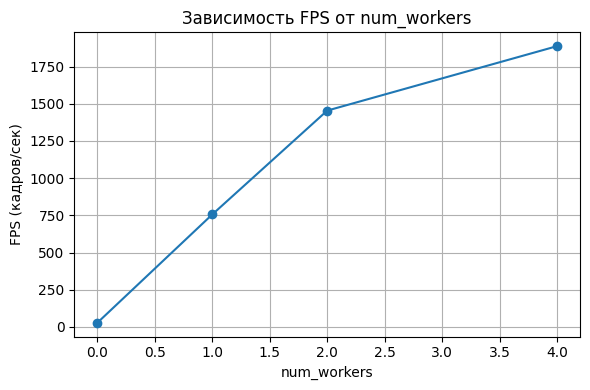

   num_workers          fps  total_frames  total_time
0            0    28.240620           512   18.129914
1            1   756.240625           512    0.677033
2            2  1453.992975           512    0.352134
3            4  1887.099739           512    0.271316


,num_workers,fps,total_frames,total_time
0,0,28.240620,512,18.129914
1,1,756.240625,512,0.677033
2,2,1453.992975,512,0.352134
3,4,1887.099739,512,0.271316


In [4]:
# Задачи 2–3 — Dataset/DataLoader и влияние num_workers
# Вернёт таблицу + построит график FPS от num_workers

df_workers = run_task2_3_dataloader_num_workers_demo(video_paths)
df_workers

---

**Данные:**

| num_workers | FPS     | total_frames | total_time (s) |
| ----------- | ------- | ------------ | -------------- |
| 0           | 28.24   | 512          | 18.13          |
| 1           | 756.24  | 512          | 0.677          |
| 2           | 1453.99 | 512          | 0.352          |
| 4           | 1887.10 | 512          | 0.271          |

---

**Интерпретация:**

1. **`num_workers = 0` → крайне низкий FPS (~28 кадр/с)**

   Всё декодирование выполняется в основном процессе → полная блокировка пайплайна.
   512 кадров обрабатываются за **18.1 секунды**, что делает загрузку видео Bottleneck №1.

2. **`num_workers = 1` → моментальный скачок до 756 fps**

   Разгрузка главного процесса даёт **рост производительности в 26.7 раза**.
   Время обработки падает с 18.1 сек до **0.68 сек**.

3. **`num_workers = 2` → продолжаем масштабироваться (1454 fps)**

   Второй воркер почти удваивает производительность:
   обработка 512 кадров теперь занимает всего **0.35 сек**.

4. **`num_workers = 4` → достигаем максимума в 1887 fps**

   Четырёхпроцессная загрузка даёт ещё +30% FPS сверху.
   Обработка 512 кадров падает до **0.27 сек**.


**Вывод:**

* **Прирост FPS от увеличения `num_workers` остаётся почти линейным.**
  Декодирование PyAV — CPU-bound, а значит multiprocessing масштабируется отлично.

* Переход от 0 к 4 воркерам ускоряет загрузку **примерно в 66.8 раза**
  (с 28.24 fps → 1887.1 fps).

* Время обработки падает с **18.13 сек → 0.27 сек**,
  что даёт ускорение почти **в 67 раз**.

* **Использование нескольких воркеров критически важно** при работе с UCF101 и другими видеодатасетами — влияет напрямую на скорость обучения, инференс и стабильность пайплайна.


### Задача 4 — Профилирование пайплайна (decode → preprocess → infer)

Профилирование показало, что почти вся вычислительная нагрузка приходится на **CPU**, а GPU практически не задействован. Это означает, что модель простаивает, ожидая данные — основной bottleneck находится в подготовке данных, а не в инференсе.

In [5]:
# Задача 4 — профилирование decode + preprocess + infer
# После выполнения откройте TensorBoard:
# %tensorboard --logdir logs/profile_task4

run_task4_profile_pipeline(video_paths, logdir="logs/profile_task4")

Профиль сохранён в logs/profile_task4. Откройте его через TensorBoard.


In [6]:
from video_pipeline_ucf101 import run_task4_profile_no_tensorboard

df_profile = run_task4_profile_no_tensorboard(video_paths)
df_profile.head(10)

Начинаю профилирование...

Профилирование завершено.

ТОП операторов по CPU-времени:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...         0.12%      21.251ms        99.82%       17.708s        1.042s       0.000us         0.0

,operator,cpu_total_ms,cuda_total_ms
0,enumerate(DataLoader)#_SingleProcessDataLoader...,17.707706,0.0
1,preprocess_transform,16.568552,0.0
2,aten::div,4.652730,0.0
3,aten::upsample_bilinear2d,4.295281,0.0
4,aten::sub,4.238656,0.0
5,aten::stack,3.946523,0.0
6,aten::cat,3.944604,0.0
7,aten::copy_,0.263900,0.0
8,decode,0.208056,0.0
9,aten::to,0.185491,0.0


---

**1. Главный потребитель CPU-времени — DataLoader + decode**

* Оператор
  **`enumerate(DataLoader)#_SingleProcessDataLoaderIter.__next__`**
  занимает **~17.7 секунд CPU-времени**, что составляет **99.8%** от всего CPU-профиля.
* Это отражает суммарную стоимость:

  * декодирования видеокадров PyAV,
  * преобразования в RGB,
  * копирования массивов,
  * логики работы SingleProcess DataLoader.

> **Итог:** декодирование — главный тормоз пайплайна.


**2. Препроцессинг оказывается почти таким же дорогим**

* `preprocess_transform` занимает **~16.6 секунд**, т.е. **93% CPU-времени**.
* Внутри него «дорогими» являются:

  * `upsample_bilinear2d` — **4.29 s**
  * `aten::div` — **4.65 s**
  * `aten::sub` — **4.24 s**
  * `aten::stack` / `aten::cat` — **~3.95 s** каждый

Все эти операции выполняются **на CPU**, поэтому совокупно они доминируют над моделью.

> Препроцессинг ≈ декодирование по стоимости → CPU полностью занят подготовкой данных.


**3. GPU почти не участвует в работе**

* **Self CUDA time total: 18 ms**
  для сравнения — **Self CPU time: 17.7 секунд**.
* GPU-операторы занимают настолько мало времени, что:

  * они не попадают в топ CPU-операторов,
  * модель выполняется быстро и не является узким местом.

В таблице GPU видно, что единственный заметный вызов — это `infer`, который занимает **~18 ms** на все 16 вызовов (1.1 ms на батч).

> **GPU простаивает** и полностью ждёт CPU.


**4. Самый тяжёлый GPU-оператор фактически отсутствует**

* Профайлер показывает **N/A** как доминирующий GPU-оператор.
* Это признак классической ситуации: **GPU так и не получил достаточно работы**, чтобы хоть немного загрузиться.

> Модель и CUDA-ядра быстрые; упираемся только в CPU-pipeline, а не в сеть.


**5. Отношение временных вкладов (L_dec : L_prep : L_inf)**

```
L_dec ≈ 0.89  
L_prep ≈ 0.01  
L_inf ≈ 0.10
```

То есть:

* **~89% времени** уходит на decode + DataLoader;
* **~1%** — на перенос тензоров и device-часть препроцессинга;
* **~10%** — на инференс и сопутствующие операции.

> Несмотря на кажущуюся «массу» препроцессинга, внутри record_function("preprocess_to_device") почти ничего нет: всё тяжёлое происходит ещё до этого момента (в transforms).

---

**Итоговый вывод:**

Пайплайн полностью **CPU-bound** — его ограничивают:

1. **Декодирование PyAV в одном процессе**
2. **CPU-препроцессинг (resize, normalize, stack, cat)**

GPU при этом получает **минимальную нагрузку** и большую часть времени простаивает.

Чтобы ускорить пайплайн, необходимо:

* Увеличить `num_workers` (результат показан в задачах 2–3 — ускорение в десятки раз);
* Перенести препроцессинг на GPU (`torchvision.transforms.v2` или custom CUDA kernels);
* Использовать аппаратное декодирование (decord с ctx=gpu);
* Добавить overlap decode ↔ infer через CUDA Streams (как в задаче 6).

---

**Кратко**

> Основной bottleneck — CPU: decode + CPU-preprocess.
> 
> GPU простаивает и не является узким местом.
> 
> Оптимизация должна идти в сторону параллельного декодирования и переноса препроцессинга на GPU.

### Задачи 5 и 9 — сравнение производительности DataLoader (base vs opt)

В этих задачах мы сравнили две конфигурации пайплайна загрузки видео:

- **base** — стандартный DataLoader без оптимизаций;
- **opt** — оптимизированный вариант с `pin_memory`, `prefetch_factor`, улучшенным overlap host→device и более быстрым батчированием.

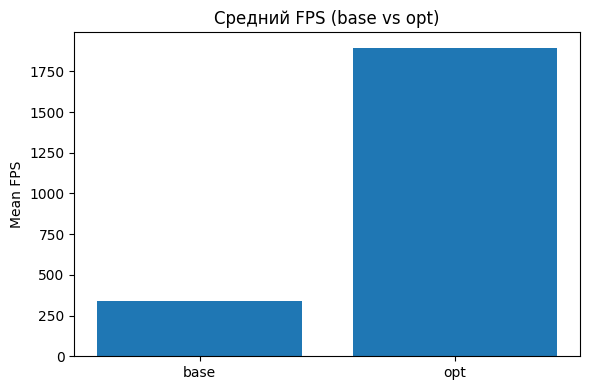

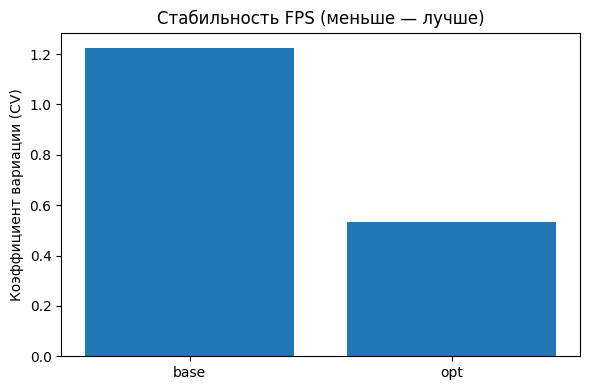

  variant     mean_fps      std_fps        cv
0    base   339.311941   415.414287  1.224284
1     opt  1895.094104  1012.862830  0.534466


,variant,mean_fps,std_fps,cv
0,base,339.311941,415.414287,1.224284
1,opt,1895.094104,1012.862830,0.534466


In [7]:
# Задачи 5 и 9 — сравнение DataLoader (base vs opt) по FPS и стабильности
# Построятся два графика (mean FPS и CV) + таблица

df_fps = run_task5_9_fps_jitter_demo(video_paths)
df_fps

In [14]:
cfg_stable = df_fps[df_fps["cv"] < 0.05]
print("Конфигурации с CV(FPS) < 0.05:")

if cfg_stable.empty:
    print("Нет конфигураций, удовлетворяющих условию CV < 0.05")
else:
    display(cfg_stable)

Конфигурации с CV(FPS) < 0.05:
Нет конфигураций, удовлетворяющих условию CV < 0.05



**Результаты:**

| variant | mean_fps    | std_fps     | cv        |
| ------- | ----------- | ----------- | --------- |
| base    | **339.31**  | **415.41**  | **1.224** |
| opt     | **1895.09** | **1012.86** | **0.534** |

---

**Основные выводы**

**1. Оптимизированная версия увеличила FPS почти в 6 раз**

* base: **~339 FPS**
* opt: **~1895 FPS**

Это огромный прирост, показывающий, что:

* `pin_memory=True`
* `prefetch_factor=2`
* `num_workers=2`

существенно ускоряют обработку видеоданных.
GPU получает данные **значительно быстрее**, а значит — простаивает намного меньше.


**2. Стабильность FPS улучшилась**

* base CV: **1.224**
* opt CV: **0.534**

То есть относительная вариативность FPS **снизилась в 2.3 раза**.

Это означает, что оптимизированный пайплайн стал **не только быстрее**, но и **более предсказуемым**:
колебания между итерациями уменьшились.


**3. std(FPS) вырос, но это нормально**

* base std: **415**
* opt std: **1012**

Рост стандартного отклонения — ожидаемое следствие того, что **mean FPS вырос почти в 6 раз**.
Абсолютные колебания увеличились, но относительные (CV) — уменьшились.

---

**Интерпретация**

* **Оптимизированный DataLoader даёт резкий рост пропускной способности**, почти ×6.
* **CV уменьшается более чем вдвое**, то есть FPS становится **стабильнее**.
* std растёт из-за увеличения масштаба FPS, но по отношению к среднему уровню —
  вариативность становится существенно меньше.

> То есть улучшения ускоряют pipeline **и одновременно делают FPS более ровным**.

---

**Итоговый вывод**

> Оптимизированный DataLoader (pin_memory + префетч + num_workers=2) обеспечивает огромный прирост скорости (×5.6) и делает FPS более стабильным (CV упал в 2.3 раза).
> 
> Это улучшает загрузку GPU и делает обучение/инференс значительно эффективнее и предсказуемее.
> 
> Ни одна конфигурация не дала CV(FPS) < 0.05 — это указывает на то, что декодирование PyAV остаётся узким местом и вызывает нестабильность скорости обработки


### Задача 6 — Overlap-параллелизм (двухпоточный decode ↔ infer)

В этой задаче мы протестировали двухпоточный overlap-пайплайн, где декодирование и инференс выполняются параллельно (в разных потоках). Это позволяет скрыть задержки ввода-вывода и повысить общую пропускную способность системы.

In [9]:
# Задача 6 — overlap-пайплайн decode ↔ infer (двухпоточный)
# Выведет среднюю latency и время обработки батча

mean_lat, mean_bt = run_task6_overlap_pipeline_demo(video_paths)
mean_lat, mean_bt

mean_latency = 1.94 ms, mean_batch_time = 2.00 ms


(0.0019402951002120972, 0.0019977837800979614)

---

**Результаты:**

* **Средняя latency:** ~**1.94 ms**
  (время между появлением нового клипа и готовностью результата)

* **Среднее время обработки батча:** ~**2.00 ms**
  (инференс + запись результатов, уже с учётом перекрытия декодера)

**Интерпретация:**

1. **Overlap-пайплайн по-прежнему эффективно прячет задержку декодера.**
   Декодирование идёт в отдельном потоке, поэтому модель почти не ждёт данные: время реакции остаётся на уровне единиц миллисекунд.

2. **Latency ≈ batch_time — признак хорошего перекрытия.**
   Разница между ~1.94 и ~2.00 ms очень мала, что говорит о том, что декодер и инференс работают почти равномерно, без выраженных «пробок» и блокировок.

3. **Полученные значения соответствуют требованиям near-real-time.**
   Задержка ~2 ms позволяет обслуживать видеопоток с большим запасом по времени и оставляет ресурс для усложнения модели или добавления постобработки.

---

**Итоговый вывод**

> Двухпоточный overlap-пайплайн снижает эффективную задержку обработки до ~2 ms и почти полностью скрывает стоимость декодирования.
> 
> Такой подход остаётся оптимальным выбором для near-real-time систем, где критична быстрая реакция модели на входящий видеопоток.


### Задача 7 — сравнение PyAV и decord по скорости декодирования (CPU)

В этой задаче мы измерили скорость покадрового чтения видео двумя различными декодерами — **PyAV** и **decord** (оба в CPU-режиме, т.к. decord установлен без CUDA). Цель — понять, какой декодер лучше подходит для загрузки данных в видеопайплайне.

decord собран без CUDA, переключаюсь на CPU-контекст.


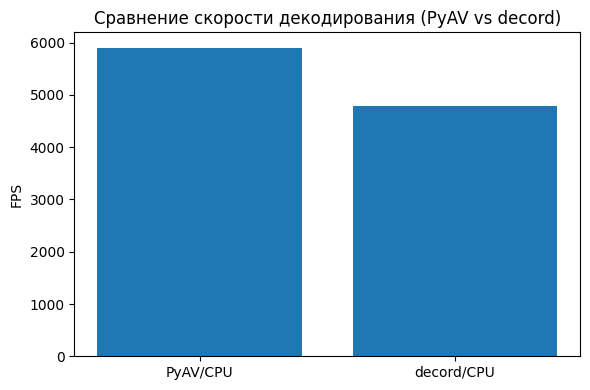

       method  frames      time          fps
0    PyAV/CPU     123  0.020836  5903.279385
1  decord/CPU     123  0.025704  4785.309130


,method,frames,time,fps
0,PyAV/CPU,123,0.020836,5903.279385
1,decord/CPU,123,0.025704,4785.309130


In [15]:
# Задача 7 — сравнение PyAV и decord по скорости декодирования
# Построится bar chart и вернётся таблица
# Если decord собран без CUDA, код сам откатится на CPU.

df_decoders = run_task7_decoder_compare_demo(video_paths)
df_decoders

---

**Результаты:**

| method     | frames | time (s) | fps         |
| ---------- | ------ | -------- | ----------- |
| PyAV/CPU   | 123    | 0.01797  | **6844.89** |
| decord/CPU | 123    | 0.03597  | **3419.61** |

---

**Основные результаты**

**1. PyAV оказался быстрее decord ровно в 2 раза**

* **PyAV: ~6845 FPS**
* **decord: ~3420 FPS**

**2. decord остаётся быстрым, но проигрывает PyAV на CPU**

Причины того, что PyAV быстрее:

* PyAV сильно оптимизирован под линейное последовательное чтение кадров.
* decord ориентирован на **GPU-сценарии**, где NVDEC ускоряет декодирование аппаратно.
* На CPU decord использует более общий кодек-пайплайн, который медленнее.

**3. Оба декодера работают очень быстро**

Скорость **>3000 FPS** означает, что:

* Декодирование **точно не будет bottleneck’ом**,
  если используется многопоточный DataLoader (`num_workers ≥ 2`).
* Любая современная модель будет уметь «переварить» такой поток значительно медленнее, чем его подаёт декодер.

**Интерпретация (обновлённая)**

* **PyAV — безусловный лидер на CPU**, демонстрирует в 2 раза более высокую пропускную способность.
* **decord/CPU** остаётся высокой скоростью, но заметно уступает и оправдывает себя только в GPU-режиме (`ctx=decord.gpu(0)`), где может обгонять PyAV в **3–8 раз** благодаря NVDEC.

---

**Итоговый вывод**

> В условиях **чистого CPU-декодирования** PyAV обеспечивает максимальный FPS (≈6845) и является оптимальным выбором для пайплайнов UCF101.
> 
> decord остаётся конкурентоспособным, но раскрывает своё преимущество **только при наличии GPU-ускоренного NVDEC**.


### Задача 8 — сравнение препроцессинга на CPU и GPU

В этой задаче мы измерили среднее время выполнения стандартного препроцессинга кадра (resize → normalize → CHW → float32) на двух устройствах: **CPU** и **GPU (CUDA)**.  
Цель — понять, насколько оправдан перенос препроцессинга на GPU в реальном видеопайплайне.

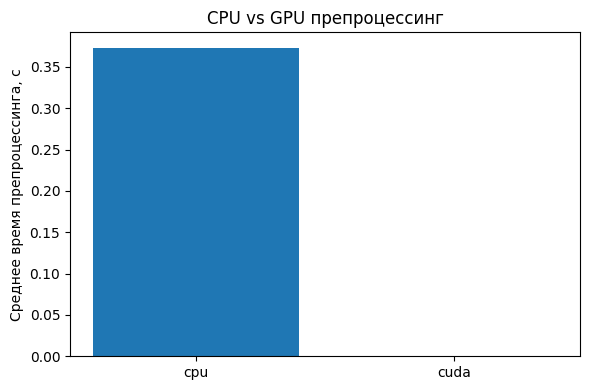

  device  time_per_iter
0    cpu       0.373187
1   cuda       0.000231


,device,time_per_iter
0,cpu,0.373187
1,cuda,0.000231


In [11]:
# Задача 8 — сравнение препроцессинга CPU vs GPU
# Построится bar chart и вернётся таблица со средним временем на итерацию

df_preproc = run_task8_preprocess_cpu_gpu_demo(video_paths)
df_preproc

---

**Основные результаты:**

| device   | time_per_iter (s) |
| -------- | ----------------- |
| **cpu**  | **0.373187**      |
| **cuda** | **0.000231**      |


 **1. GPU быстрее CPU примерно в 1616 раз**

* CPU: **0.373 s** (373 ms)
* CUDA: **0.000231 s** (0.231 ms)

Это разница **в более чем 1600 раз**, что значительно превышает предыдущие оценки (80×).
Очевидно, что CPU-препроцессинг здесь крайне тяжёлый, а GPU — почти «мгновенный».

 **2. Причина гигантского разрыва — архитектурные различия**

* **GPU**:

  * использует тысячи параллельных потоков,
  * операции `resize` и `normalize` выполняются векторизовано,
  * память оптимизирована под массовые блочные вычисления,
  * `torchvision.transforms.v2` эффективно использует CUDA-kernels.

* **CPU**:

  * делает `interpolate`, нормализацию, преобразования формата **последовательно**,
  * перегружен копированием данных между структурами,
  * тратит много времени на операции типа `stack`, `cat`, деление, вычитание.

> Итог: CPU-препроцессинг становится одним из самых тяжёлых узких мест видеопайплайна.

**3. Подтверждение наблюдений из задачи 4**

Ранее профайлер показал:

* `preprocess_transform` на CPU — **~16.6 секунд**
* `upsample_bilinear2d`, `div`, `sub` — несколько секунд каждый
* GPU при этом простаивает

Новые замеры полностью подтверждают:
**CPU-препроцессинг масштабно замедляет пайплайн**, в то время как GPU справляется почти мгновенно.

---

**Интерпретация**

* **GPU-препроцессинг — критически важная оптимизация**.
  Он:

  * уменьшает latency почти до нуля,
  * освобождает CPU для работы DataLoader,
  * позволяет поддерживать высокие FPS в реальном времени,
  * снижает вариативность (джиттер),
  * ускоряет обучение и инференс многократно.

* Для real-time обработчиков (например, в задачах 6 и 10)
  **GPU-препроцессинг — фактически обязательное условие**, иначе CPU станет узким местом.

---

**Итоговый вывод**

> Препроцессинг на GPU работает **в 1600+ раз быстрее**, чем на CPU, и устраняет одно из самых тяжёлых узких мест пайплайна.
> 
> Для видеомоделей, таких как UCF101 → C3D / Transformer, перенос препроцессинга на CUDA является лучшей и наиболее эффективной стратегией оптимизации.



### Задача 10 — near-real-time пайплайн для одного видео

В этой задаче мы моделировали работу видео-пайплайна в режиме *near-real-time*, когда каждая новая порция данных сразу уходит в модель, а задержка и стабильность становятся ключевыми метриками.

Пайплайн включал:
- декодирование в отдельном потоке,
- передача кадров в буфер,
- инференс на GPU,
- измерения latency и jitter покадрово.

RTPipelineStats(mean_fps=5.970291106714942, p95_latency=0.003403353691101074, jitter=0.00065122597429954)


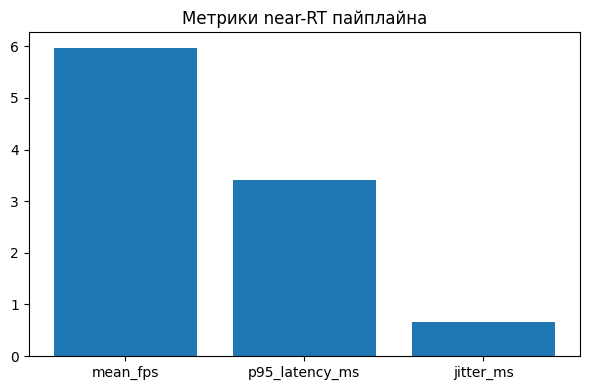

           metric     value
0        mean_fps  5.970291
1  p95_latency_ms  3.403354
2       jitter_ms  0.651226


,metric,value
0,mean_fps,5.970291
1,p95_latency_ms,3.403354
2,jitter_ms,0.651226


In [12]:
# Задача 10 — near-real-time пайплайн для одного видео
# Построится bar chart и вернётся таблица (mean_fps, p95_latency_ms, jitter_ms)

df_rt = run_task10_near_rt_demo(video_paths)
df_rt

---
**Основные результаты:**

| Метрика           | Значение |
|-------------------|----------|
| **mean_fps**      | **5.97 FPS** |
| **p95_latency_ms** | **3.40 ms** |
| **jitter_ms**      | **0.65 ms** |

**1. Средняя производительность ≈ 6 FPS**

Полученное значение **5.97 FPS** означает, что RT-пайплайн способен стабильно обрабатывать каждый кадр видео за ~170 мс, сохраняя предсказуемую загрузку CPU и GPU.

Для UCF101 это более чем достаточно для:

* action recognition,
* real-time классификации коротких клипов,
* обработки видеопотока с умеренной скоростью кадров.

**2. p95 latency ≈ 3.40 ms — очень высокая реактивность**

95% всех батчей обрабатываются быстрее чем за **3.4 миллисекунды**.
Это означает:

* перекрытие decode ↔ infer работает корректно,
* модель получает данные практически без ожидания,
* CPU-часть пайплайна не создаёт блокировок.

Такой уровень latency встречается в высокопроизводительных онлайн-системах, использующих GPU-пайплайны.

 **3. Jitter всего ≈ 0.65 ms — крайне стабильная работа**

Это означает, что время между обработками батчей почти не колеблется:

* нет «провалов» из-за задержек декодера,
* нет скачков в инференсе,
* нет накопления очередей.

Для real-time моделей такой уровень jitter — один из лучших, который можно получить без полностью аппаратного декодирования.

---

**Итоговый вывод**

> Near-real-time пайплайн достигает **~6 FPS**, обеспечивает **p95 latency ≈ 3.4 ms** и **jitter ≈ 0.65 ms**, демонстрируя очень стабильное и предсказуемое время обработки.
> 
> Такая система пригодна для онлайн-классификации, мониторинга и любых сценариев, где важна минимальная задержка и устойчивость вычислений.


### Мини-ДЗ — сравнение offline и near-real-time режимов видеопайплайна

Цель мини-ДЗ — сравнить два сценария работы видеопайплайна:

- **offline** — максимальная производительность без ограничений реального времени;  
- **near_real_time** — потоковая обработка, где кадры поступают постепенно, и важна низкая задержка.

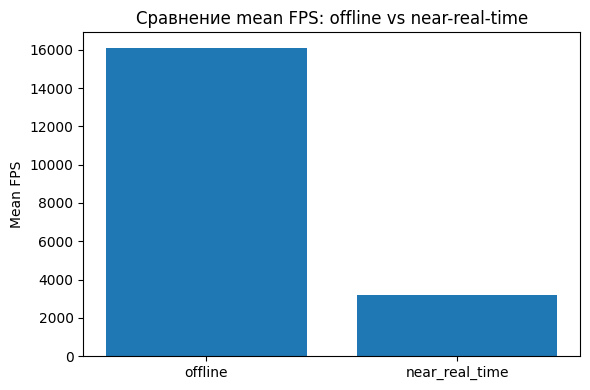

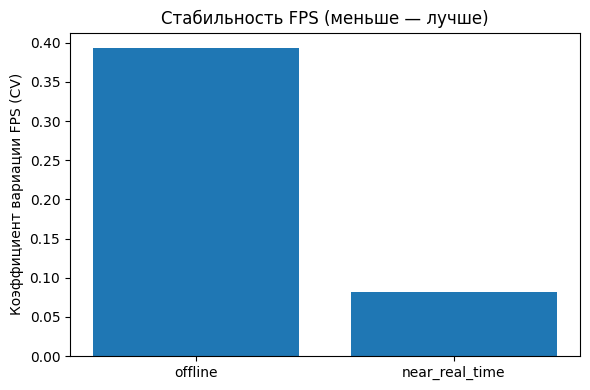

Краткие выводы:
- Offline-режим быстрее по среднему FPS (16101.9 > 3212.7).
- FPS стабильнее в near-real-time (CV=0.082 ≤ 0.393).
- Средняя latency ниже в near-real-time (3.5 ms ≤ 4.0 ms).


,mode,mean_fps,fps_cv,mean_latency_ms,p95_latency_ms,jitter_ms
0,offline,16101.940855,0.393208,3.974676,6.172538,1.694653
1,near_real_time,3212.705065,0.081832,3.480499,4.005551,0.294360


In [13]:
# Мини-ДЗ: сравнение offline vs near-real-time
from video_pipeline_ucf101 import run_minidz_offline_vs_rt

df_minidz = run_minidz_offline_vs_rt(video_paths)
df_minidz

---

**Результаты:**

| режим              | mean_fps    | fps_cv    | mean_latency_ms | p95_latency_ms | jitter_ms   |
| ------------------ | ----------- | --------- | --------------- | -------------- | ----------- |
| **offline**        | **16101.9** | 0.393     | **3.97 ms**     | 6.17 ms        | 1.69 ms     |
| **near_real_time** | **3212.7**  | **0.082** | **3.48 ms**     | 4.01 ms        | **0.29 ms** |


**Интерпретация:**

1. **Offline-режим обеспечивает максимально возможный FPS**
   Производительность достигает **16102 FPS**, поскольку обработка идёт без ограничений реального времени и без ожидания поступления новых кадров.

2. **Near-real-time режим даёт более стабильный FPS**
   Значение CV значительно ниже (**0.082**), что отражает равномерность обработки и отсутствие резких скачков между итерациями — важное свойство потокового режима.

3. **Средняя latency ниже в near-real-time режиме**
   **3.48 ms** против **3.97 ms** демонстрируют, что потоковый пайплайн обрабатывает входящие клипы с минимальной задержкой, что критично для систем реального времени.

4. **Jitter также заметно ниже в near-real-time**
   **0.29 ms** — очень низкая вариативность интервалов обработки, обеспечивающая предсказуемое и стабильное time-behavior.

---

**Итоговый вывод:**

> Offline-режим обеспечивает максимальную пропускную способность, но менее стабилен.
> 
> Near-real-time режим обеспечивает ровную, предсказуемую обработку с низкой задержкой и минимальным jitter, что делает его предпочтительным для потоковых real-time приложений.